In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfield
from visualization import *
from dataset import get_boston_housing_dataset_pytorch
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = "cpu"
device

'cpu'

In [3]:
train_loader, test_loader, maximum_label_value = get_boston_housing_dataset_pytorch(batch_size = 5, seed = np.random.randint(5000))

In [4]:
x, y = next(iter(train_loader))
x.shape

torch.Size([5, 13])

In [5]:
activation = hard_sigmoid
architecture = [13, 13, 1]

beta = 1
lambda_ = 0.99995
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.5, 0.2]), 'fb': np.array([0.15, 0.3])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation, device = device)

In [6]:
trn_rmse_list = []
tst_rmse_list = []
debug_iteration_point = 1
n_epochs = 25

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device).T, y.to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    if epoch_ % debug_iteration_point == 0:
        ## Train Evaluations
        gt_list = []
        pred_list = []
        for x, y in train_loader:
            x, y = x.to(device).T, y.to(device).T
            neurons = model.init_neurons(x.size(1), device = device)
            (neurons,
             _,
             _
             ) = model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, neural_dynamic_iterations_free, 0, False)
            output = neurons[-1]
            gt_list += (list(maximum_label_value*torch2numpy(y).reshape(-1,)))
            pred_list += (list(maximum_label_value*torch2numpy(output).reshape(-1,)))
        train_RMSE = np.sqrt(((np.array(gt_list) - np.array(pred_list)) ** 2).mean())
        trn_rmse_list.append(train_RMSE)
        ## Test Evaluation

        gt_list = []
        pred_list = []
        for x, y in test_loader:
            x, y = x.to(device).T, y.to(device).T
            neurons = model.init_neurons(x.size(1), device = device)
            (neurons,
             _,
             _
             ) = model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, neural_dynamic_iterations_free, 0, False)
            output = neurons[-1]
            gt_list += (list(maximum_label_value*torch2numpy(y).reshape(-1,)))
            pred_list += (list(maximum_label_value*torch2numpy(output).reshape(-1,)))

        test_RMSE = np.sqrt(((np.array(gt_list) - np.array(pred_list)) ** 2).mean())
        tst_rmse_list.append(test_RMSE)
        
        print("Train RMSE : {}, Test RMSE : {}".format(train_RMSE, test_RMSE))

81it [00:02, 38.67it/s]
3it [00:00, 26.25it/s]

Train RMSE : 11.64264965057373, Test RMSE : 11.482666015625


81it [00:02, 39.74it/s]
3it [00:00, 28.87it/s]

Train RMSE : 11.41048812866211, Test RMSE : 11.242842674255371


81it [00:02, 37.17it/s]
3it [00:00, 26.00it/s]

Train RMSE : 10.474076271057129, Test RMSE : 10.153045654296875


81it [00:02, 36.84it/s]
2it [00:00, 14.74it/s]

Train RMSE : 9.324532508850098, Test RMSE : 8.91068172454834


81it [00:02, 35.52it/s]
3it [00:00, 26.47it/s]

Train RMSE : 8.530771255493164, Test RMSE : 8.321528434753418


81it [00:02, 36.91it/s]
3it [00:00, 29.95it/s]

Train RMSE : 7.953821182250977, Test RMSE : 7.586055755615234


81it [00:02, 37.66it/s]
3it [00:00, 26.28it/s]

Train RMSE : 7.556983470916748, Test RMSE : 7.323997974395752


81it [00:02, 37.31it/s]
3it [00:00, 28.45it/s]

Train RMSE : 7.381608963012695, Test RMSE : 6.977054119110107


81it [00:02, 37.49it/s]
3it [00:00, 28.18it/s]

Train RMSE : 7.164227485656738, Test RMSE : 7.03420877456665


81it [00:02, 37.04it/s]
3it [00:00, 28.40it/s]

Train RMSE : 7.1179609298706055, Test RMSE : 7.153410911560059


81it [00:02, 37.90it/s]
3it [00:00, 25.24it/s]

Train RMSE : 6.818130970001221, Test RMSE : 6.571526527404785


81it [00:02, 39.39it/s]
4it [00:00, 36.00it/s]

Train RMSE : 6.6501359939575195, Test RMSE : 6.513274669647217


81it [00:02, 37.19it/s]
3it [00:00, 29.70it/s]

Train RMSE : 6.49142599105835, Test RMSE : 6.435492992401123


81it [00:02, 35.85it/s]
3it [00:00, 25.12it/s]

Train RMSE : 6.585930347442627, Test RMSE : 6.853700637817383


81it [00:02, 36.98it/s]
4it [00:00, 35.93it/s]

Train RMSE : 6.216251850128174, Test RMSE : 6.155246257781982


81it [00:02, 37.52it/s]
4it [00:00, 30.28it/s]

Train RMSE : 6.105947494506836, Test RMSE : 6.015402317047119


81it [00:02, 37.60it/s]
4it [00:00, 29.66it/s]

Train RMSE : 5.939725875854492, Test RMSE : 6.029397487640381


81it [00:02, 38.24it/s]
3it [00:00, 25.40it/s]

Train RMSE : 5.818084716796875, Test RMSE : 5.948678016662598


81it [00:02, 36.91it/s]
4it [00:00, 32.28it/s]

Train RMSE : 5.693708896636963, Test RMSE : 5.926304340362549


81it [00:02, 39.48it/s]
3it [00:00, 28.08it/s]

Train RMSE : 5.581214904785156, Test RMSE : 5.855567932128906


81it [00:02, 39.64it/s]
4it [00:00, 37.60it/s]

Train RMSE : 5.498441696166992, Test RMSE : 5.830440044403076


81it [00:02, 39.18it/s]
3it [00:00, 27.42it/s]

Train RMSE : 5.406545639038086, Test RMSE : 5.668432235717773


81it [00:02, 35.02it/s]
4it [00:00, 35.78it/s]

Train RMSE : 5.32991886138916, Test RMSE : 5.61430549621582


81it [00:02, 37.41it/s]
3it [00:00, 29.86it/s]

Train RMSE : 5.258307933807373, Test RMSE : 5.5672430992126465


81it [00:02, 36.80it/s]


Train RMSE : 5.214779853820801, Test RMSE : 5.593833923339844


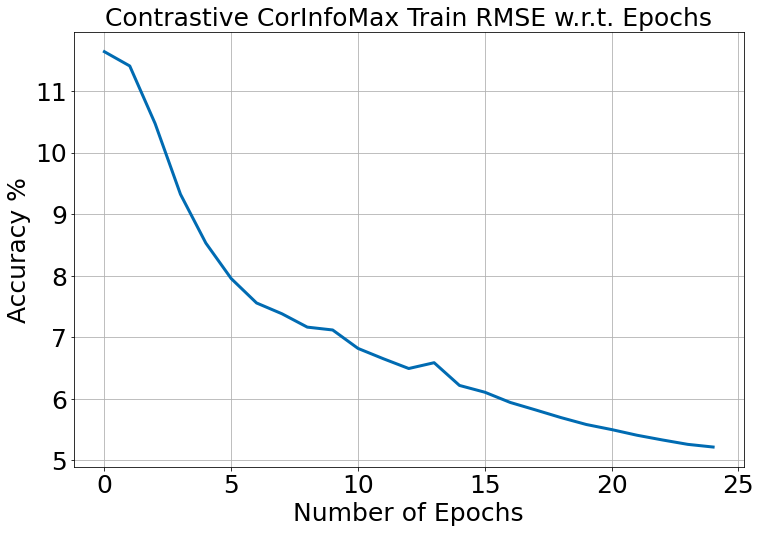

In [7]:
plot_convergence_plot(trn_rmse_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train RMSE w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

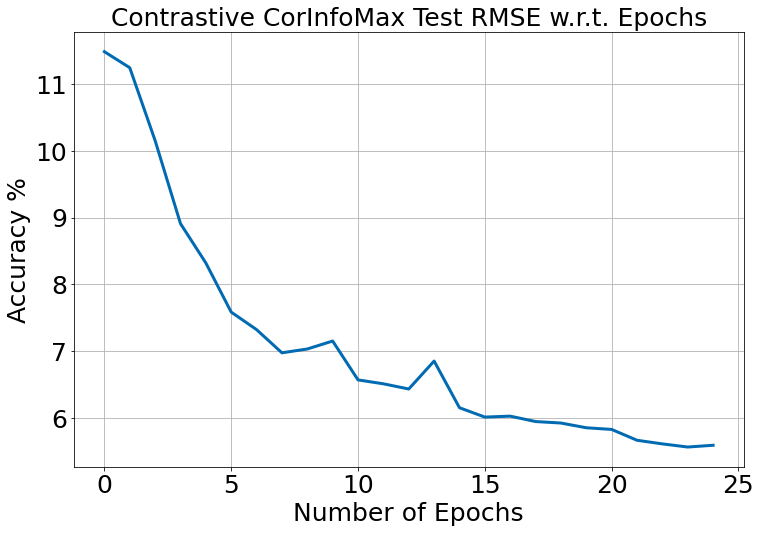

In [8]:
plot_convergence_plot(tst_rmse_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test RMSE w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [9]:
gt_list = []
pred_list = []

for x, y in train_loader:
    x, y = x.to(device).T, y.to(device).T
    neurons = model.init_neurons(x.size(1), device = device)
    (neurons,
     _,
     _
     ) = model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free, 0, False)
    output = neurons[-1]
    gt_list += (list(maximum_label_value*torch2numpy(y).reshape(-1,)))
    pred_list += (list(maximum_label_value*torch2numpy(output).reshape(-1,)))

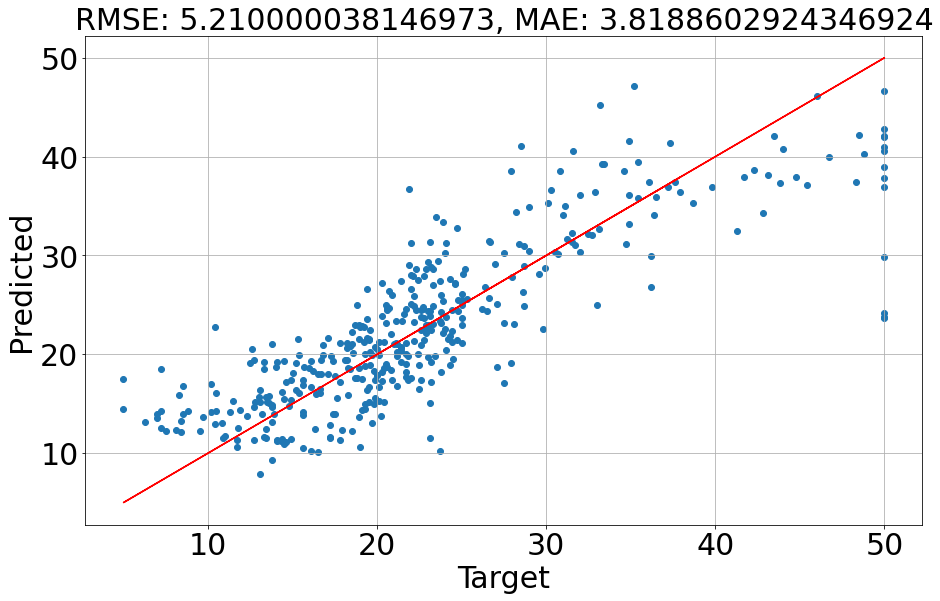

In [10]:
plot_regression_quality(target = np.array(gt_list), pred = np.array(pred_list))

In [11]:
gt_list = []
pred_list = []

for x, y in test_loader:
    x, y = x.to(device).T, y.to(device).T
    neurons = model.init_neurons(x.size(1), device = device)
    (neurons,
     _,
     _
     ) = model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free, 0, False)
    output = neurons[-1]
    gt_list += (list(maximum_label_value*torch2numpy(y).reshape(-1,)))
    pred_list += (list(maximum_label_value*torch2numpy(output).reshape(-1,)))

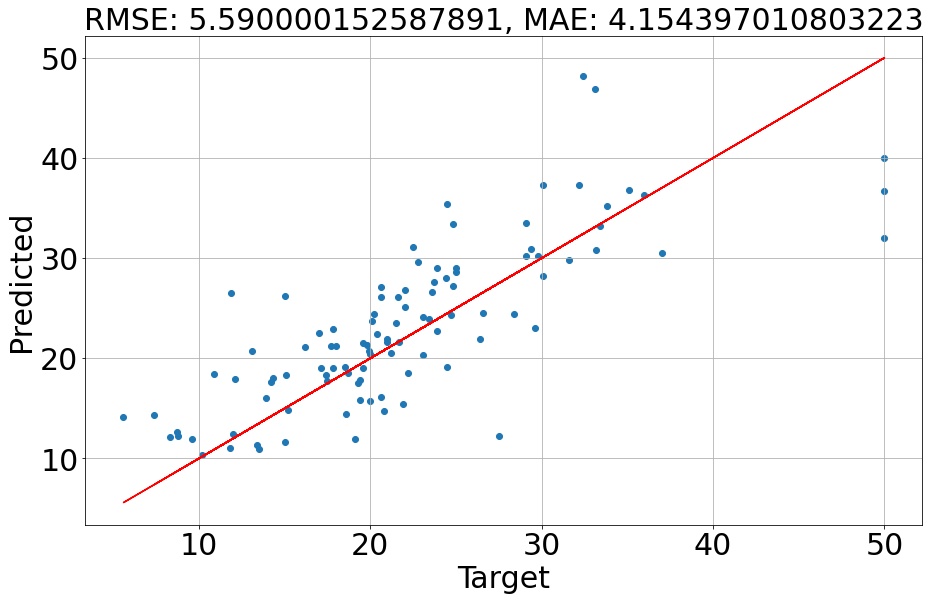

In [12]:
plot_regression_quality(target = np.array(gt_list), pred = np.array(pred_list))

In [13]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [14]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [15]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [16]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [17]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])